In [1]:
%run ../stdPackages.ipynb
from pyDbs import *
from IPython.display import Image
figs_path = os.path.join(d['curr'],'Figs')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
path_to_data = os.path.join(d['curr'],'E44','Data','E44_Data.xlsx')
print(path_to_data)

c:\Users\Peter Bendix\OneDrive\Skrivebord\EnergyEconomicsE2024\Exercises\E44\Data\E44_Data.xlsx


In [3]:
kwargs = {'variables': ['Fundamentals', 'Load', 'Generators_Other'],
        'maps': ['Generators_Categories','hMaps'],
        'variable2D': ['HourlyVariation','Generators_FuelMix'],
        'scalars': ['Scalars']}

db = read.dbFromWB(path_to_data, kwargs)
readSets(db)

In [4]:
import sys
sys.path.append(os.path.join(d['curr'], 'E44', 'py'))
from ModelClass_SolutionGuide import *
m = mSimple(db)
m()

Solution status 0: Optimization terminated successfully. (HiGHS Status 7: Optimal)


In [5]:
#Baseline solution saved
base_db = m.db.copy()

In [6]:
#Fuel Aggregation
agg_BFt = {
    'Fueloil':'Oil','Gasoil':'Oil', 
    'Straw':'Biomass','WoodPellets':'Biomass','WoodChips':'Biomass','WoodWaste':'Biomass',
    'Biogas':'Other Bio','BioOil':'Other Bio',
    'Coal':'Coal',
    'NatGas':'Natural gas',
    'Waste':'Waste'
}

- `id6` is a wind farm with a marginal costs of generation of 3 $€/$GJ. The installed/theoretical capacity if 25 but the average/practical generating capacity is only around 7.5.
- `id4` is a relatively cheap waste incineration plant, which is associted with CO$_2$ emissions.
- `id1` is next on the merit order curve and is predominately a coal plant. Even though it is not the most fuel inefficient generator it has by far the largest emission intensity.
- `id2` is a predominately a natural-gas fired plant and has the second highest emission intensity.
- `id3` is a biomass-fired plant associated with moderate CO$_2$ emissions since it also uses a small input of coal.
- `id5` is the last generator on the merit order curve and it is relatively costly mainly due to high fuel costs. 

In [14]:
extract = ['marginalSystemCosts','Generation','charge','discharge','capturePrice','marketValueFactor','capacityFactor','marginalEconomicValue','hourlyEmissions','Emissions','consumerSurplus','producerSurplus','Welfare']

In [ ]:
# Settings for model solving
E2P = 6  # The "energy storage to power"-ratio/storage duration
maxcap = 10  
loop = pd.Index(range(11), name='loop')  

# Different efficiency levels
effS_levels = [0.80, 0.85, 0.90, 0.95, 0.99]

v0_ECap = pd.Series(0.001, index=getTechs(['Storage'], m.db))
vT_ECap = pd.Series(maxcap, index=v0_ECap.index)
v0_SCap = v0_ECap.mul(E2P)
vT_SCap = vT_ECap.mul(E2P)

grid_ECap = adjMultiIndex.addGrid(v0_ECap, vT_ECap, loop, 'GeneratingCapacity').astype(int)
grid_SCap = adjMultiIndex.addGrid(v0_SCap, vT_SCap, loop, 'sCap').astype(int)

results = []

# Run with different efficiency levels
for effS in effS_levels:
    m.db['effS'] = effS
    
    solution = m.loopSolveExtract(loop, [grid_ECap, grid_SCap], extract)
    
    results.append({
        'effS': effS,
        'solution': solution,
        'Emissions': solution['Emissions'].sum(),
        'Welfare': solution['Welfare'].sum()
    })

results_df = pd.DataFrame(results)


   effS                                           solution     Emissions  \
0  0.80  {'marginalSystemCosts': [10.885989986529339, 1...  45944.863442   
1  0.85  {'marginalSystemCosts': [10.885989986529339, 1...  45975.505316   
2  0.90  {'marginalSystemCosts': [10.885989986529339, 1...  45842.635755   
3  0.95  {'marginalSystemCosts': [10.885989986529339, 1...  45651.781172   
4  0.99  {'marginalSystemCosts': [10.885989986529339, 1...  45506.194954   

        Welfare  
0  6.057438e+07  
1  6.065927e+07  
2  6.075422e+07  
3  6.086649e+07  
4  6.095228e+07  


In [ ]:
# Solve the model with the baseline efficiency level of 90%
m.db['effS'] = 0.90

solution1 = m.loopSolveExtract(loop, [grid_ECap, grid_SCap], extract)

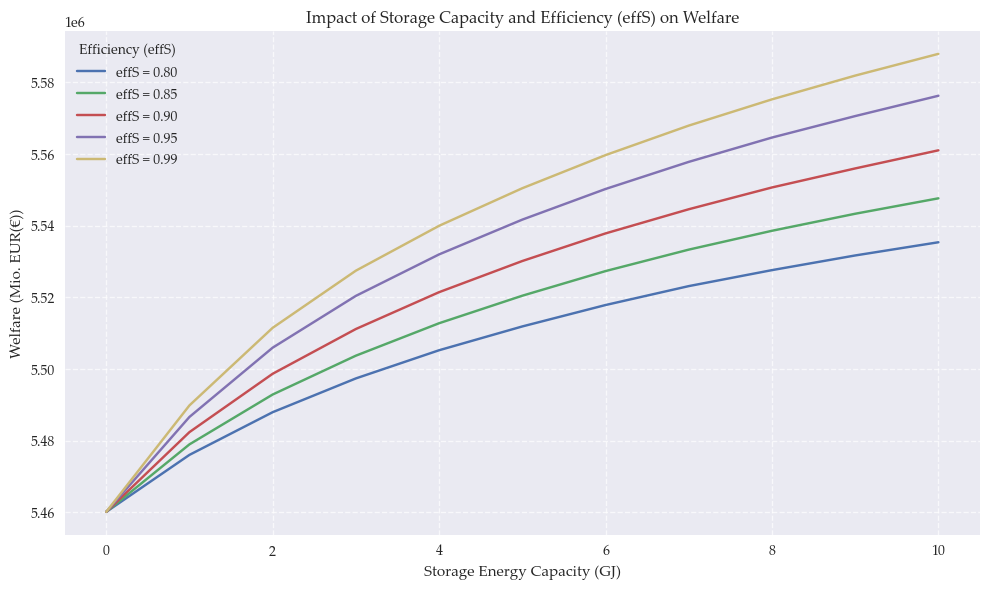

In [ ]:
# Initialize the plot of welfare vs. storage capacity
plt.figure(figsize=(10, 6))

for result in results:
    effS = result['effS']
    welfare = result['solution']['Welfare']
    
    plt.plot(loop, welfare, label=f'effS = {effS:.2f}')

plt.xlabel('Storage Energy Capacity (GJ)')
plt.ylabel('Welfare (Mio. EUR(€))')
plt.title('Impact of Storage Capacity and Efficiency (effS) on Welfare')
plt.legend(title='Efficiency (effS)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


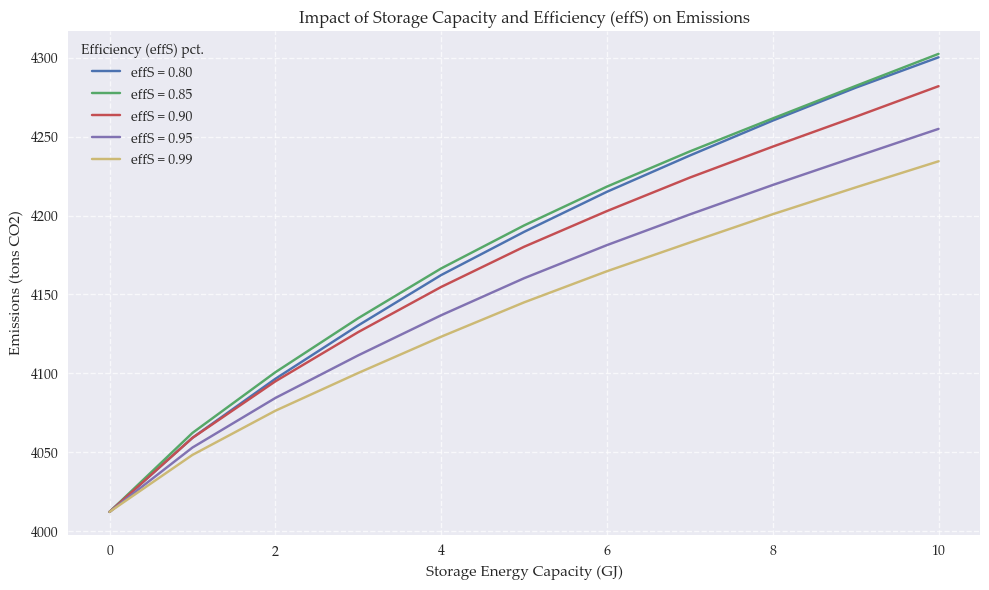

In [ ]:
# Initialize the plot of emissions
plt.figure(figsize=(10, 6))

for result in results:
    effS = result['effS']
    emissions = result['solution']['Emissions']
    
    plt.plot(loop, emissions, label=f'effS = {effS:.2f}')

plt.xlabel('Storage Energy Capacity (GJ)')
plt.ylabel('Emissions (tons CO2)')
plt.title('Impact of Storage Capacity and Efficiency (effS) on Emissions')
plt.legend(title='Efficiency (effS) pct.')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()



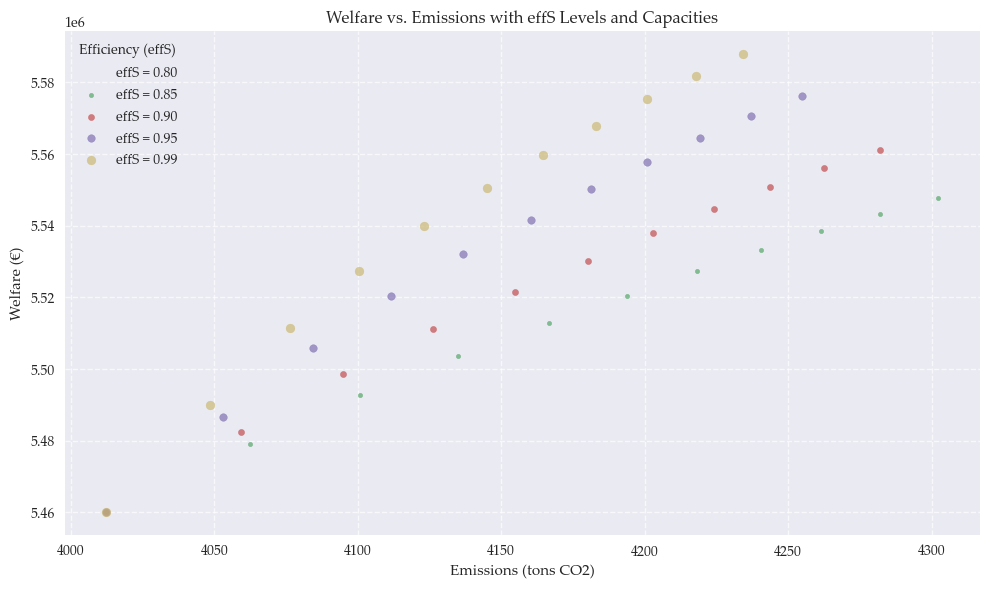

In [ ]:
# Initialize the plot of Welfare vs. Emissions
plt.figure(figsize=(10, 6))

for i, result in enumerate(results):
    effS = result['effS']
    emissions = result['solution']['Emissions']
    welfare = result['solution']['Welfare']
    capacity = grid_ECap.iloc[i] 
    
    plt.scatter(emissions, welfare, s=capacity * 10, alpha=0.7, label=f'effS = {effS:.2f}')  # Scale marker size for visibility

plt.xlabel('Emissions (tons CO2)')
plt.ylabel('Welfare (€)')
plt.title('Welfare vs. Emissions with effS Levels and Capacities')
plt.legend(title='Efficiency (effS)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()



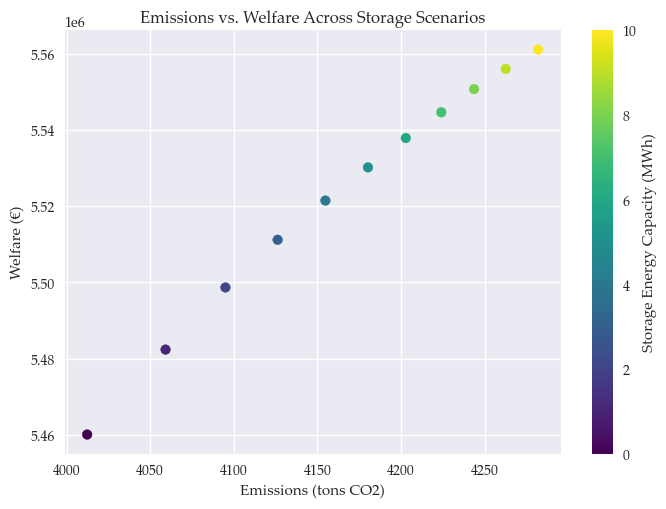

In [ ]:
#scatter plot of emissions vs. welfare when effS = 0.90
plt.scatter(solution1['Emissions'], solution1['Welfare'], c=grid_ECap, cmap='viridis')
plt.xlabel('Emissions (tons CO2)')
plt.ylabel('Welfare (€)')
plt.colorbar(label='Storage Energy Capacity (MWh)')
plt.title('Emissions vs. Welfare Across Storage Scenarios')
plt.show()


In [ ]:
trade_off_results = []

# Calculate trade-off for each result
for result in results:
    effS = result['effS']
    emissions = result['solution']['Emissions']*1000  # Convert to kg
    welfare = result['solution']['Welfare']
    
    delta_emissions = emissions.diff()  
    delta_welfare = welfare.diff()      
    
    trade_off = delta_emissions / delta_welfare
    
    trade_off_results.append({
        'effS': effS,
        'trade_off': trade_off.mean()  
    })

trade_off_df = pd.DataFrame(trade_off_results)


   effS  trade_off
0  0.80   4.170943
1  0.85   3.591241
2  0.90   2.919940
3  0.95   2.350045
4  0.99   1.998762


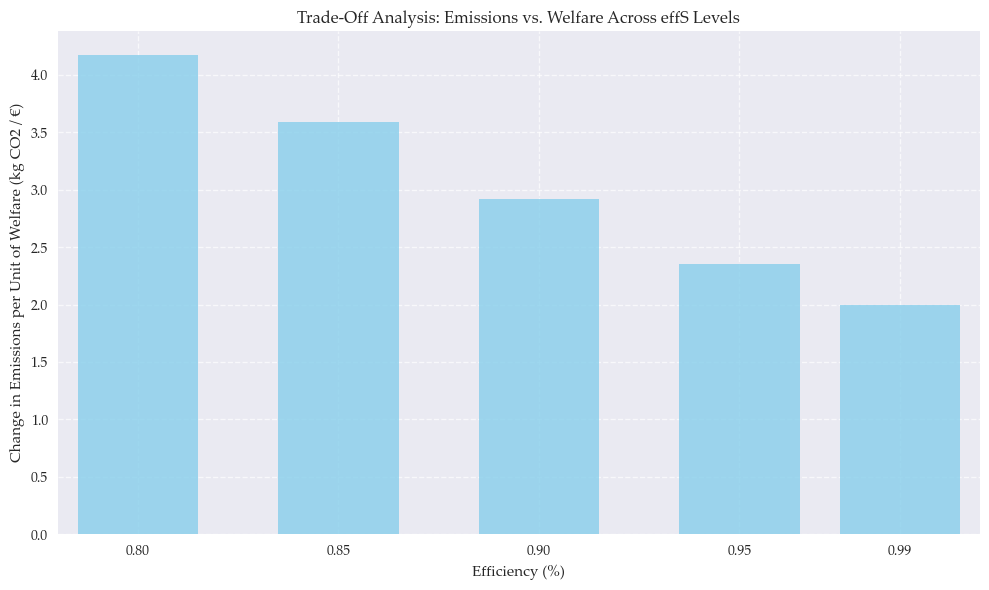

In [ ]:
# Initialize the plot of the trade-off analysis
plt.figure(figsize=(10, 6))

plt.bar(trade_off_df['effS'], trade_off_df['trade_off'], width=0.03, color='skyblue', alpha=0.8)

plt.xticks(ticks=trade_off_df['effS'], labels=[f"{eff:.2f}" for eff in trade_off_df['effS']])
plt.xlim(0.78, 1.01) 

plt.xlabel('Efficiency (%)')
plt.ylabel('Change in Emissions per Unit of Welfare (kg CO2 / €)')
plt.title('Trade-Off Analysis: Emissions vs. Welfare Across effS Levels')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()



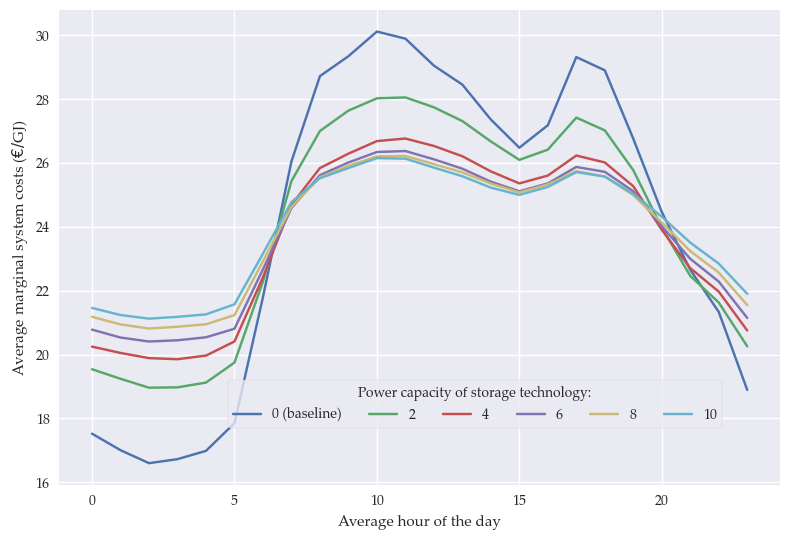

In [ ]:
# Initialize the plot of hourly marginal system costs
loop_id = loop[[2, 4, 6, 8, 10]]

df_p = pd.concat([
    base_db['marginalSystemCosts'].rename('base').astype(float),
    adj.rc_pd(solution1['marginalSystemCosts'], loop_id).unstack('loop').rename_axis(None, axis=1).astype(float)
], axis=1)


p_names = df_p.columns.copy()
df = df_p.reset_index().merge(m.db['h2HourOfTheDay'].to_frame(index=False))


fig, ax = plt.subplots()
df.groupby('HourOfTheDay')[p_names].mean().plot(xlabel='Average hour of the day', ylabel=r'Average marginal system costs ($€/$GJ)', ax=ax, legend=False)
fig.legend(['0 (baseline)'] + grid_ECap[loop_id].tolist(), loc='lower center', ncol=len(df_fuelineff.columns), frameon=True, bbox_to_anchor=(0.6, 0.2), title=r'Power capacity of storage technology:')
fig.tight_layout()

plt.show()
